### Convert Data 
Download matchup data from https://fantasyhelper.net/
reformat the data with this script

In [1]:
import pandas as pd

# Load the original CSV file
file_path = '../Data/Yahoo-431.l.148152-Matchup.csv'
data = pd.read_csv(file_path)

# Group the data by 'Week'
grouped_data = data.groupby('Week')

# Define a dictionary for team ID to name mapping
team_id_to_name = {
    '431.l.148152.t.1': 'Drew',
    '431.l.148152.t.2': 'Cameron',
    '431.l.148152.t.3': 'Micah',
    '431.l.148152.t.4': 'Evan',
    '431.l.148152.t.5': 'Kevin',
    '431.l.148152.t.6': 'Phil',
    '431.l.148152.t.7': 'Eduardo',
    '431.l.148152.t.8': 'Ben',
    '431.l.148152.t.9': 'James',
    '431.l.148152.t.10': 'Nick'
}

# Combine all normalized data into a single DataFrame for each team
team_sheets = {}

for week, group in grouped_data:
    normalized_data = pd.DataFrame()
    
    for _, row in group.iterrows():
        # Team 1 data
        team_1_data = {
            'Week': row['Week'],
            'Team ID': row['Team 1 ID'],
            'Team Name': row['Team 1 Name'],
            'Points': row['Team 1 Points'],
            'R': row['Team 1 R'],
            'HR': row['Team 1 HR'],
            'RBI': row['Team 1 RBI'],
            'SB': row['Team 1 SB'],
            'AVG': row['Team 1 AVG'],
            'W': row['Team 1 W'],
            'SV': row['Team 1 SV'],
            'K': row['Team 1 K'],
            'ERA': row['Team 1 ERA'],
            'WHIP': row['Team 1 WHIP']
        }
        team_1_id = row['Team 1 ID']
        if team_1_id not in team_sheets:
            team_sheets[team_1_id] = pd.DataFrame()
        team_sheets[team_1_id] = pd.concat([team_sheets[team_1_id], pd.DataFrame(team_1_data, index=[0])], ignore_index=True)
        
        # Team 2 data
        team_2_data = {
            'Week': row['Week'],
            'Team ID': row['Team 2 ID'],
            'Team Name': row['Team 2 Name'],
            'Points': row['Team 2 Points'],
            'R': row['Team 2 R'],
            'HR': row['Team 2 HR'],
            'RBI': row['Team 2 RBI'],
            'SB': row['Team 2 SB'],
            'AVG': row['Team 2 AVG'],
            'W': row['Team 2 W'],
            'SV': row['Team 2 SV'],
            'K': row['Team 2 K'],
            'ERA': row['Team 2 ERA'],
            'WHIP': row['Team 2 WHIP']
        }
        team_2_id = row['Team 2 ID']
        if team_2_id not in team_sheets:
            team_sheets[team_2_id] = pd.DataFrame()
        team_sheets[team_2_id] = pd.concat([team_sheets[team_2_id], pd.DataFrame(team_2_data, index=[0])], ignore_index=True)

# Save all teams' data into a single Excel file with each team having its own sheet with shortened names
excel_file_path = '../Data/Yahoo-431.l.148152-Matchup_Auto.xlsx'
with pd.ExcelWriter(excel_file_path) as writer:
    for team_id, df in team_sheets.items():
        sheet_name = team_id_to_name.get(team_id, team_id.split('.')[-1])
        df.to_excel(writer, sheet_name=sheet_name, index=False)

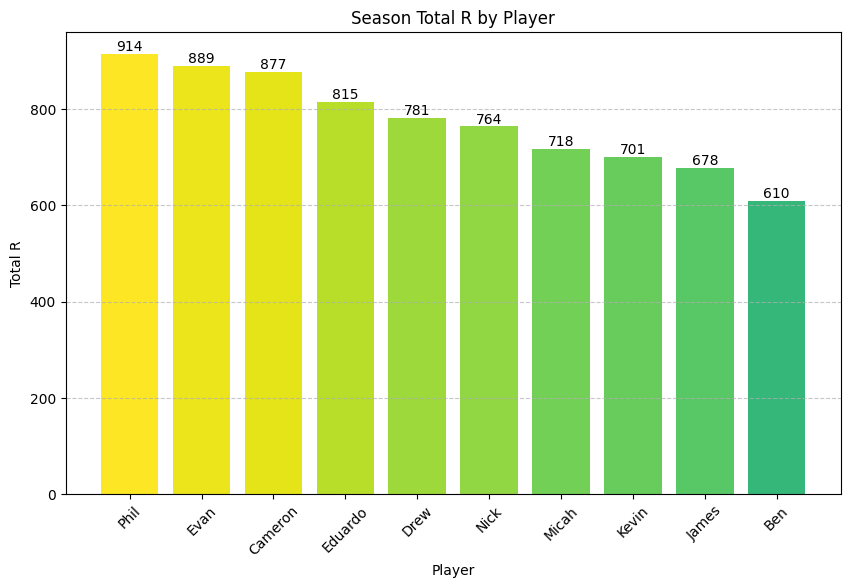

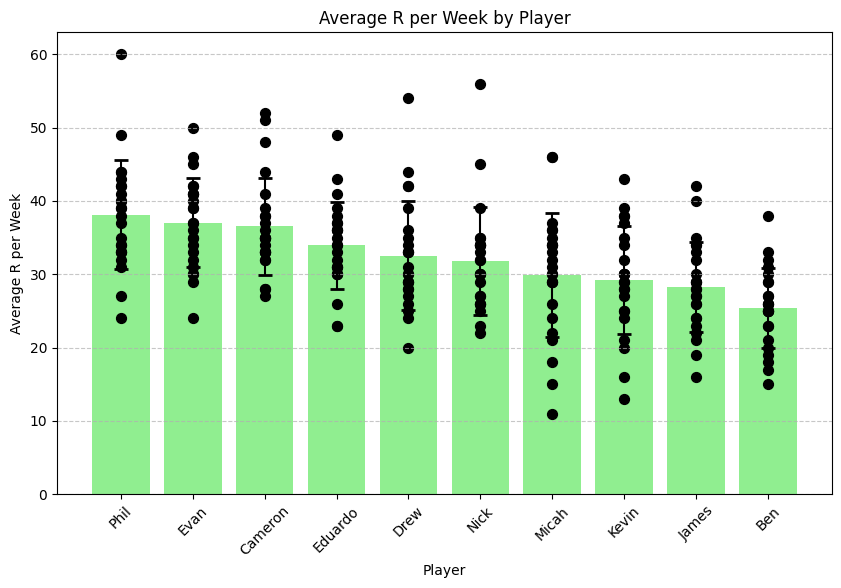

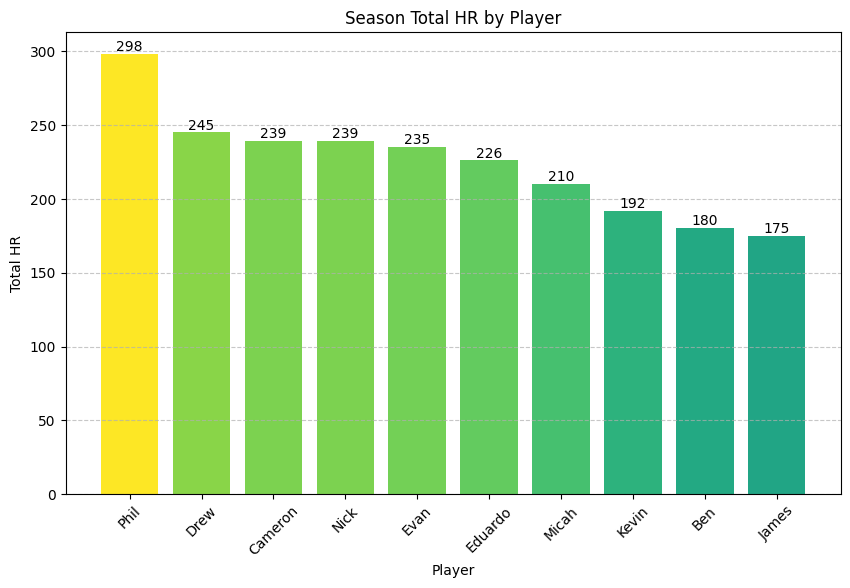

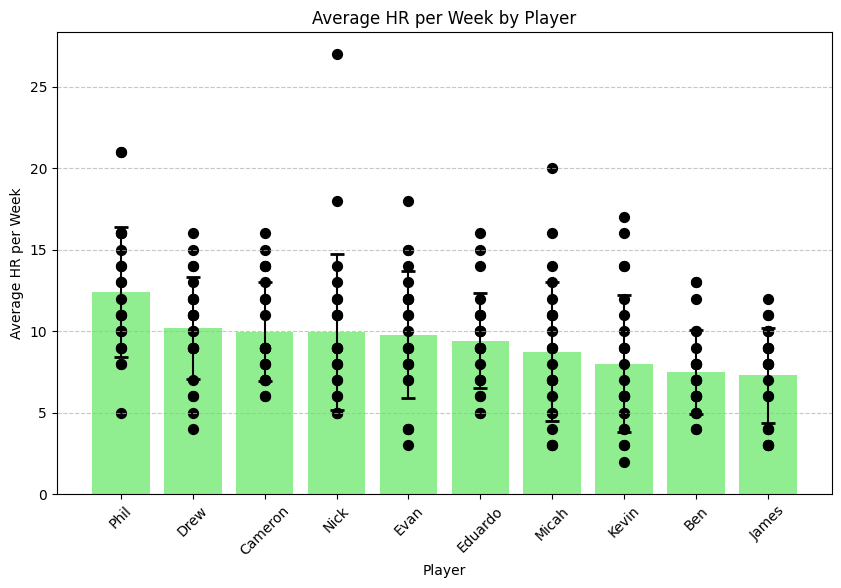

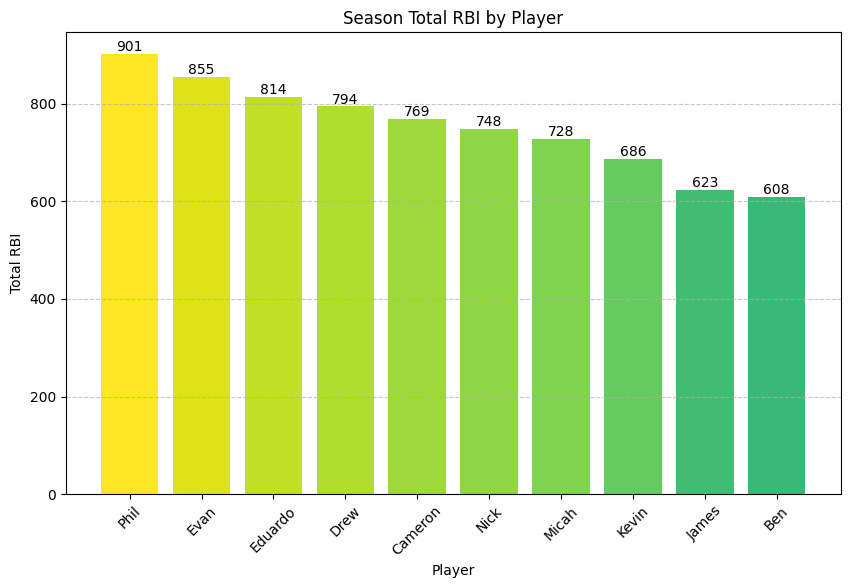

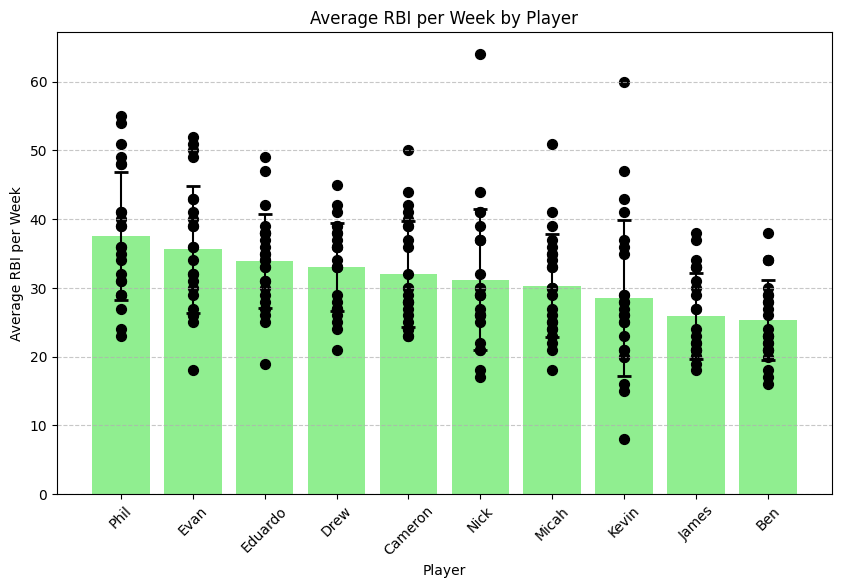

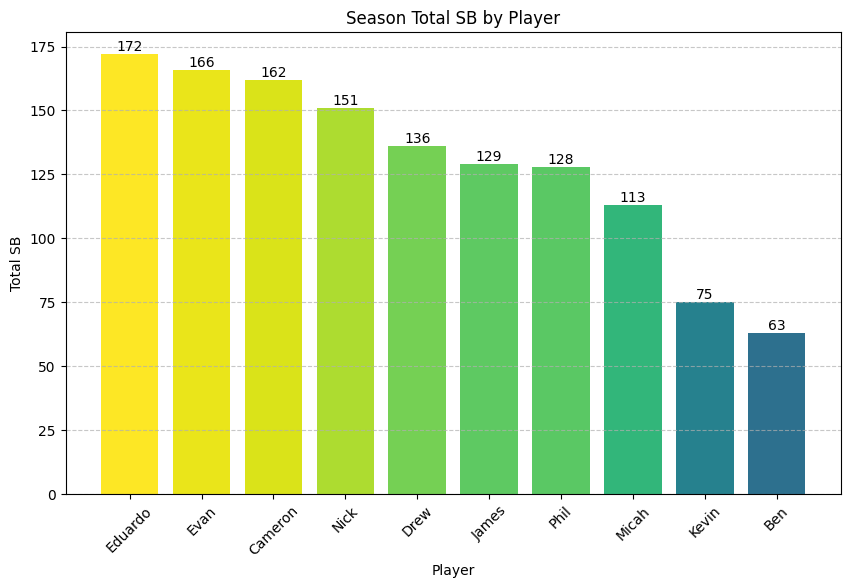

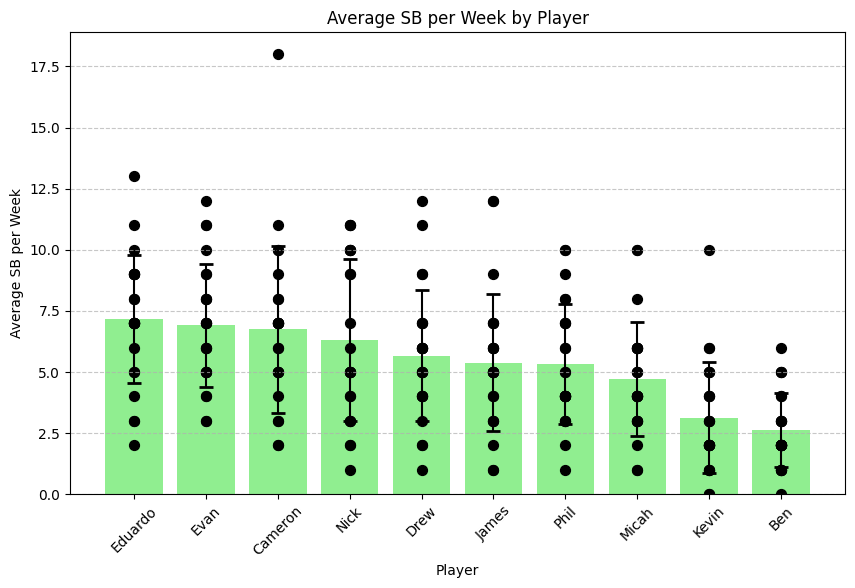

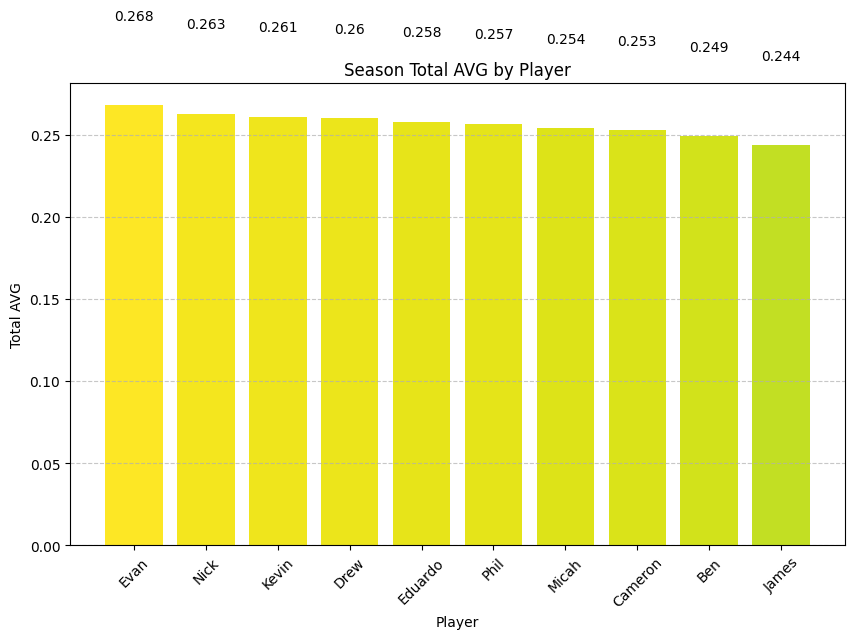

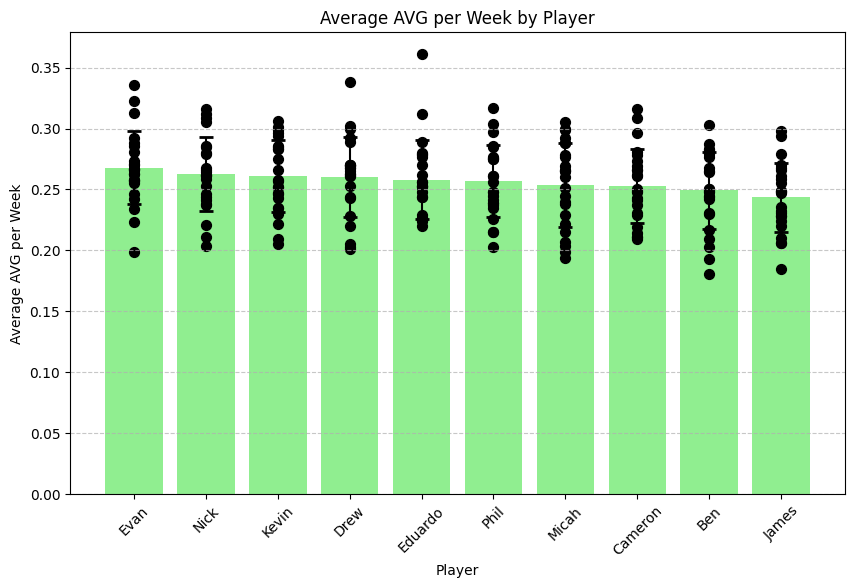

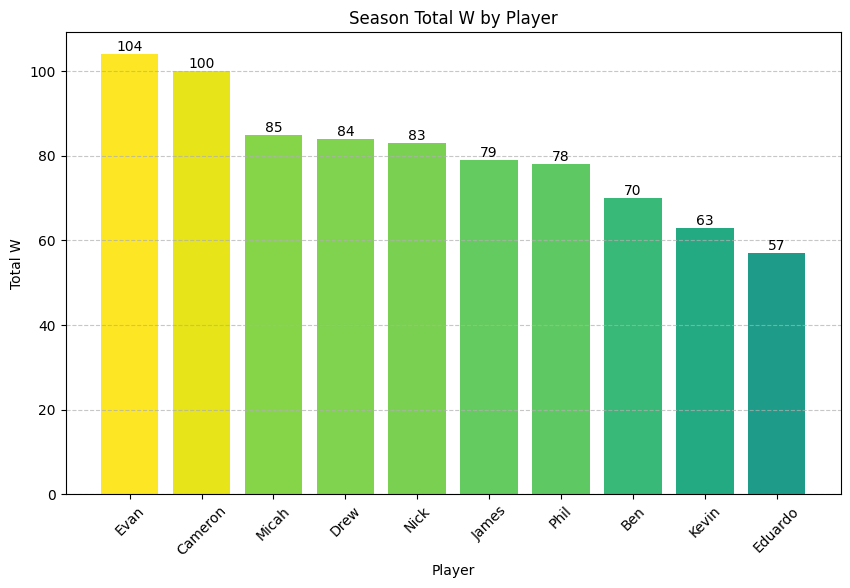

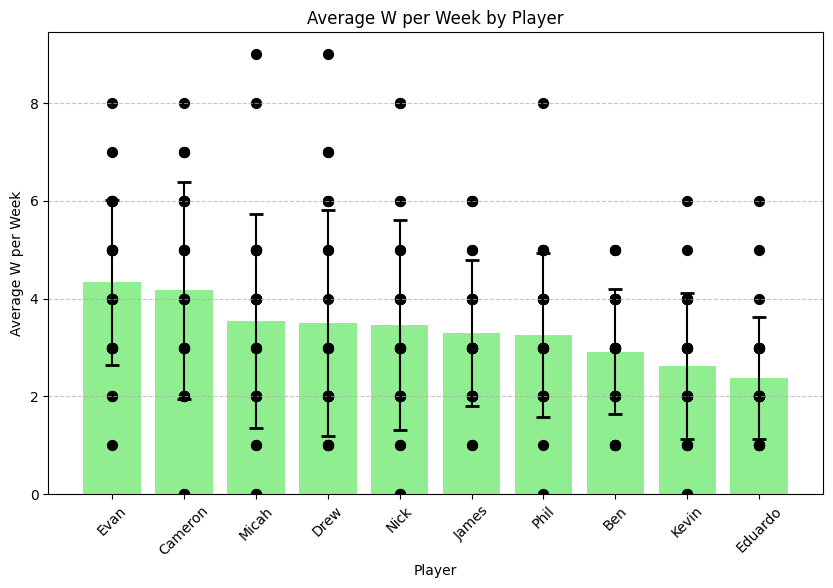

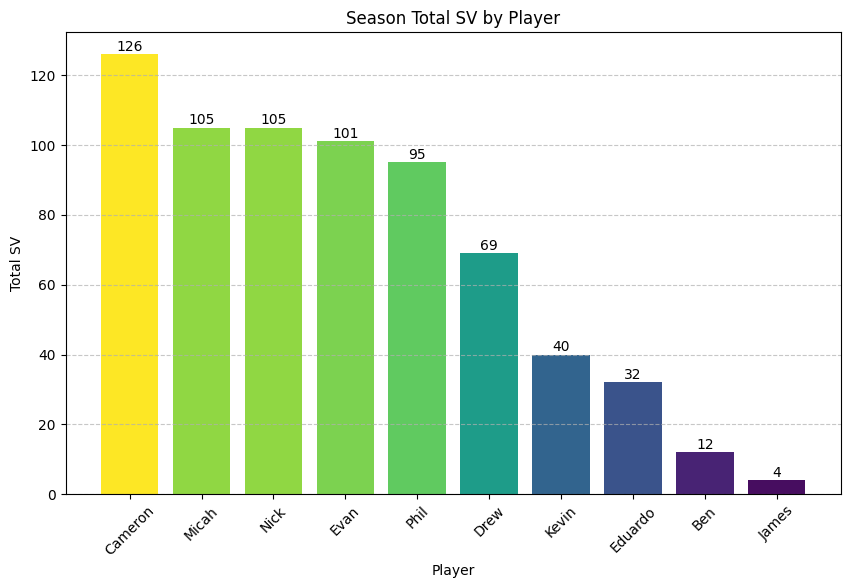

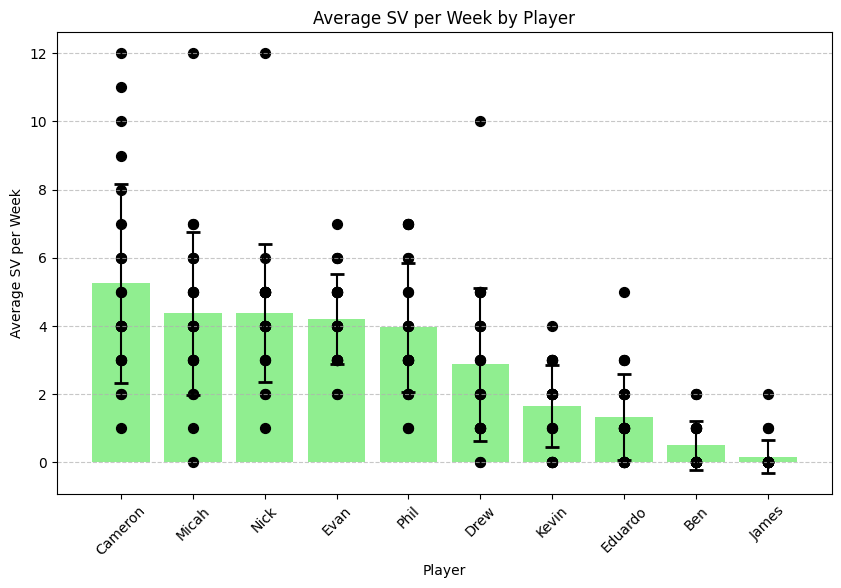

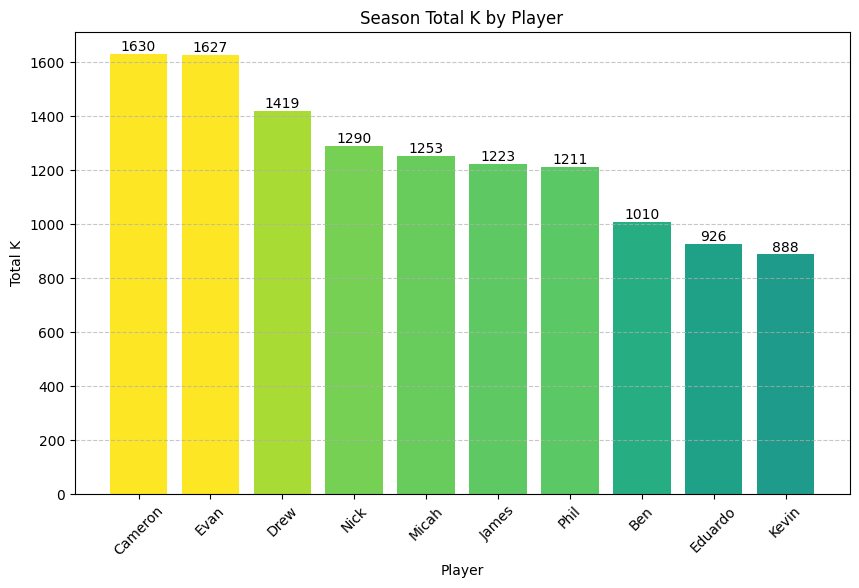

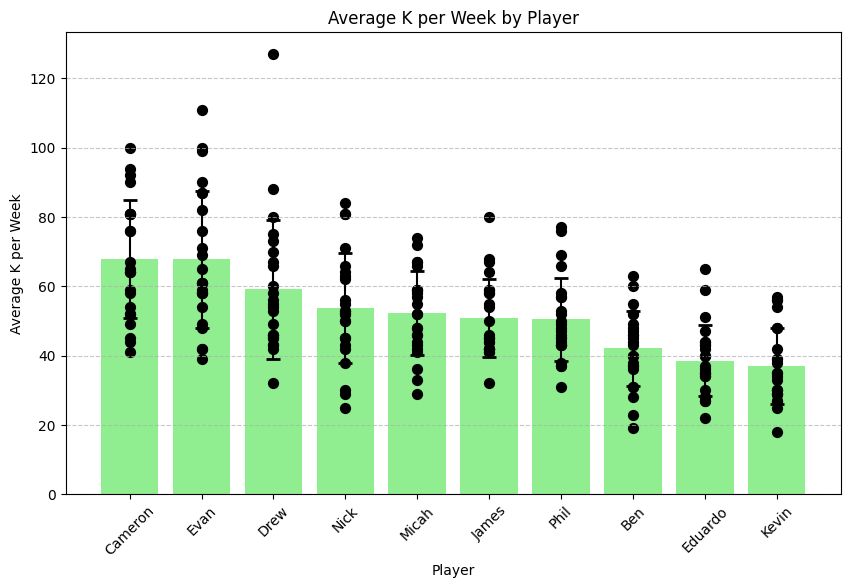

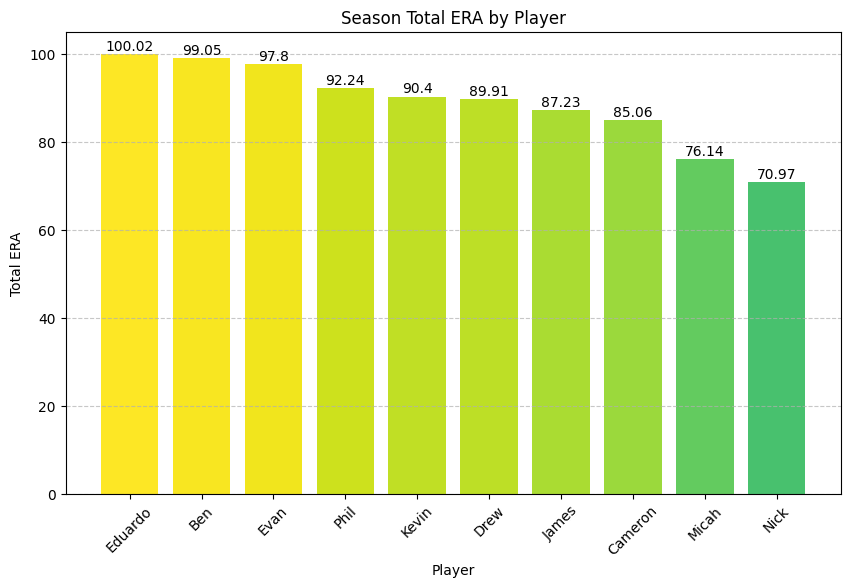

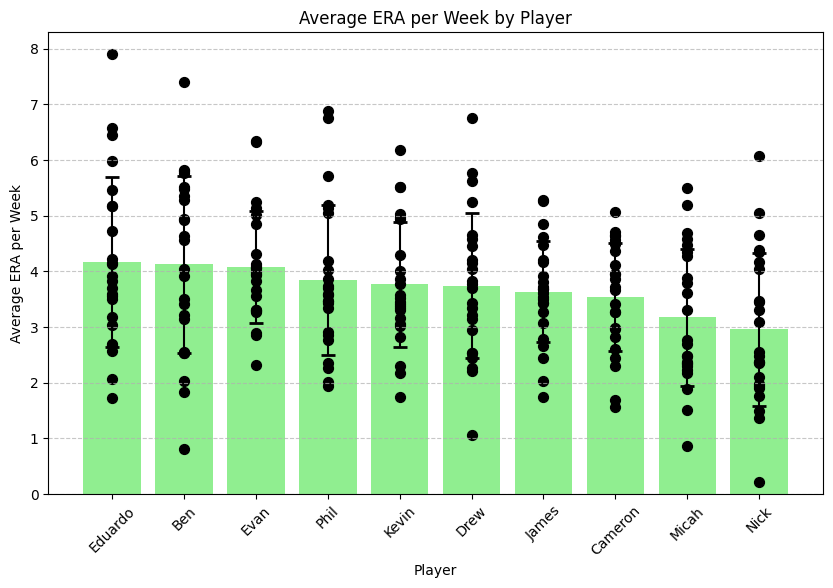

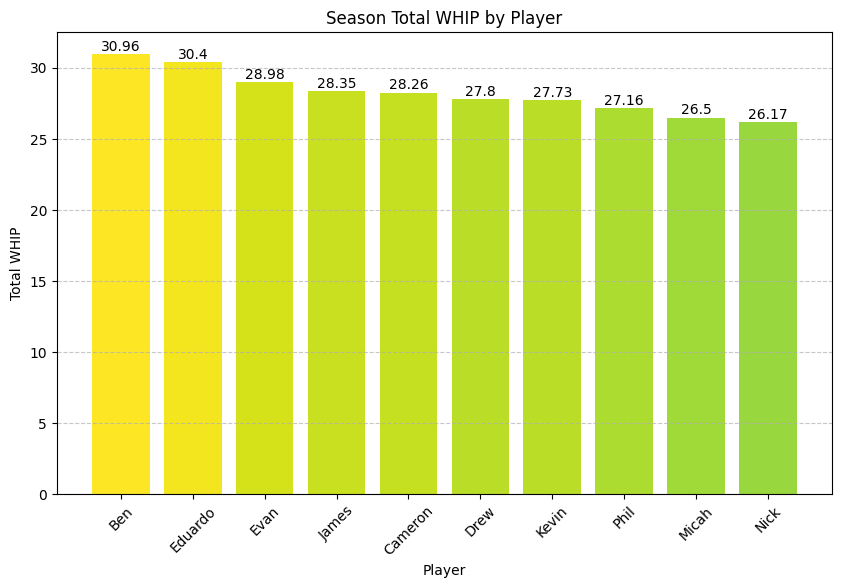

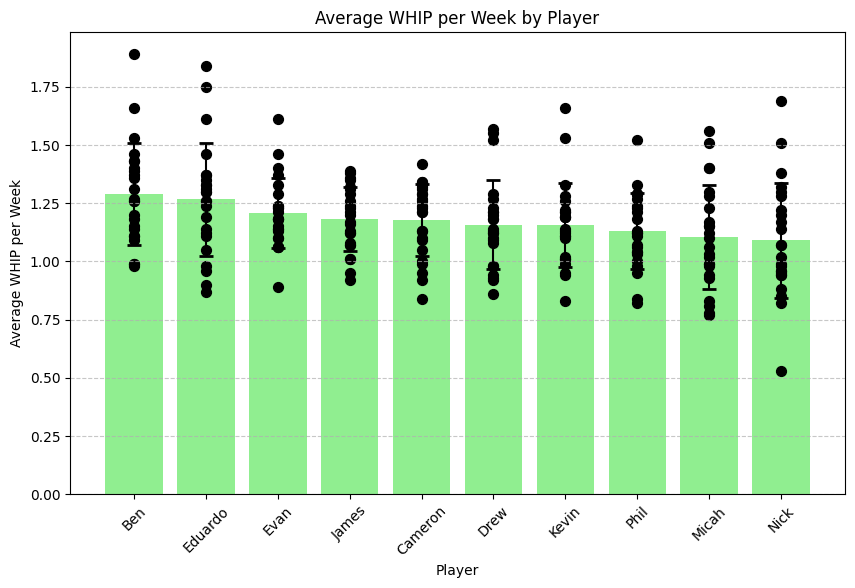

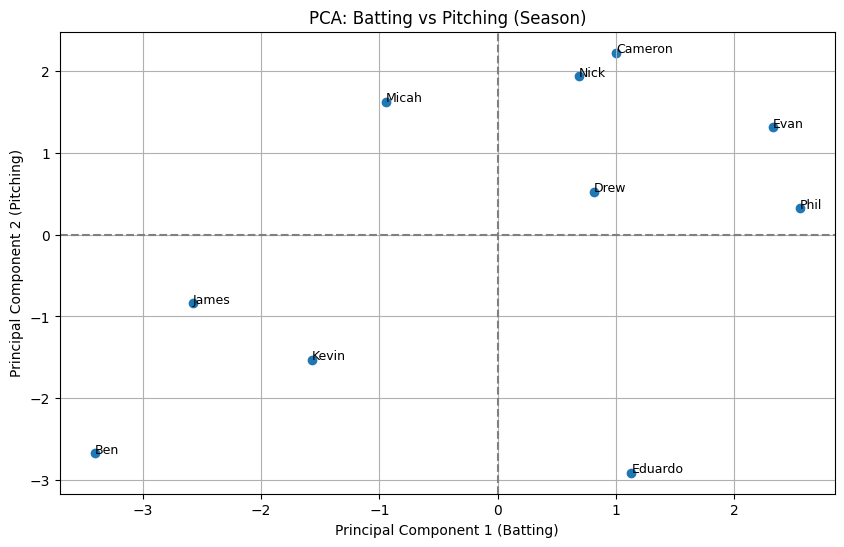

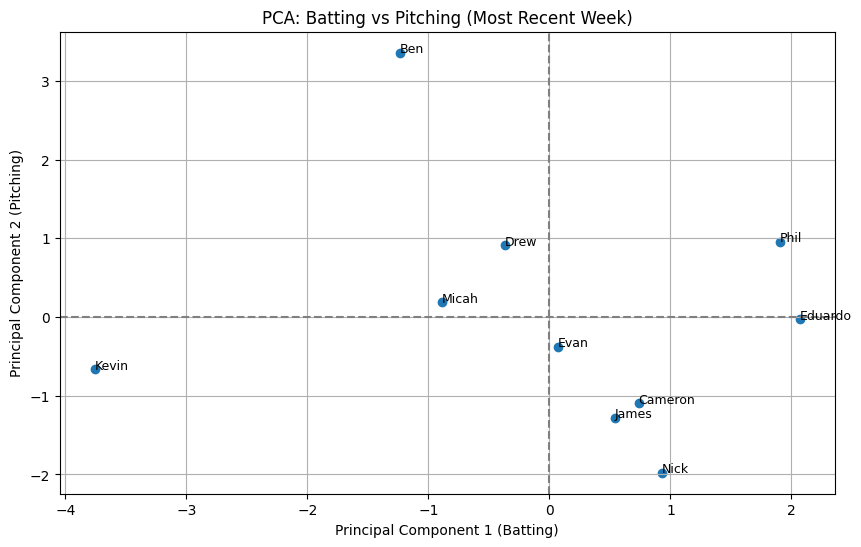

Head-to-head comparisons saved to ../Results/head_to_head_comparisons.csv


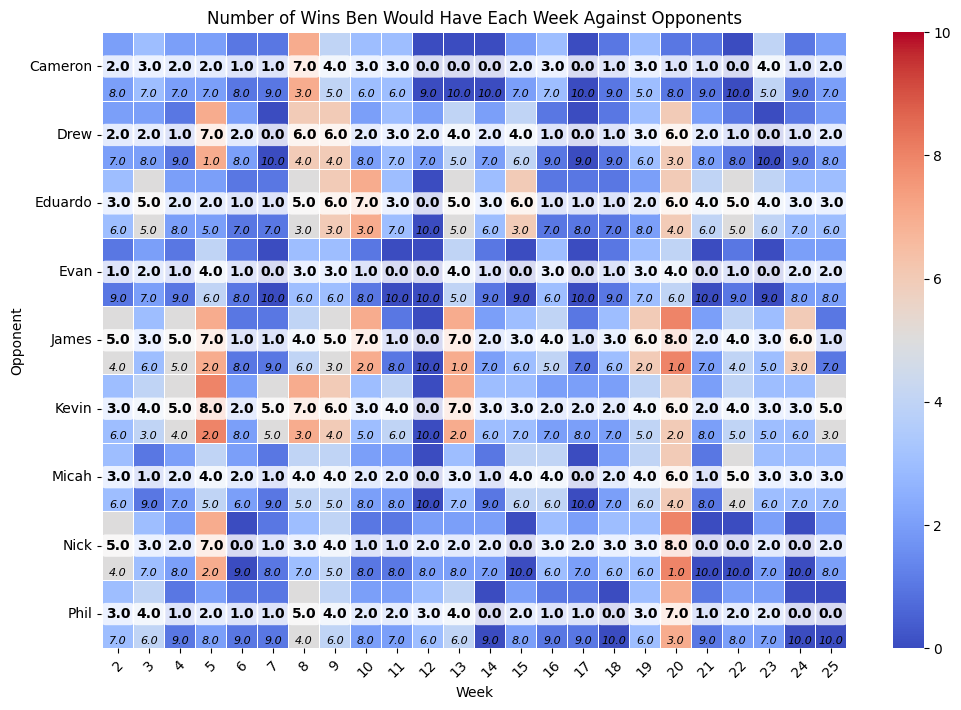

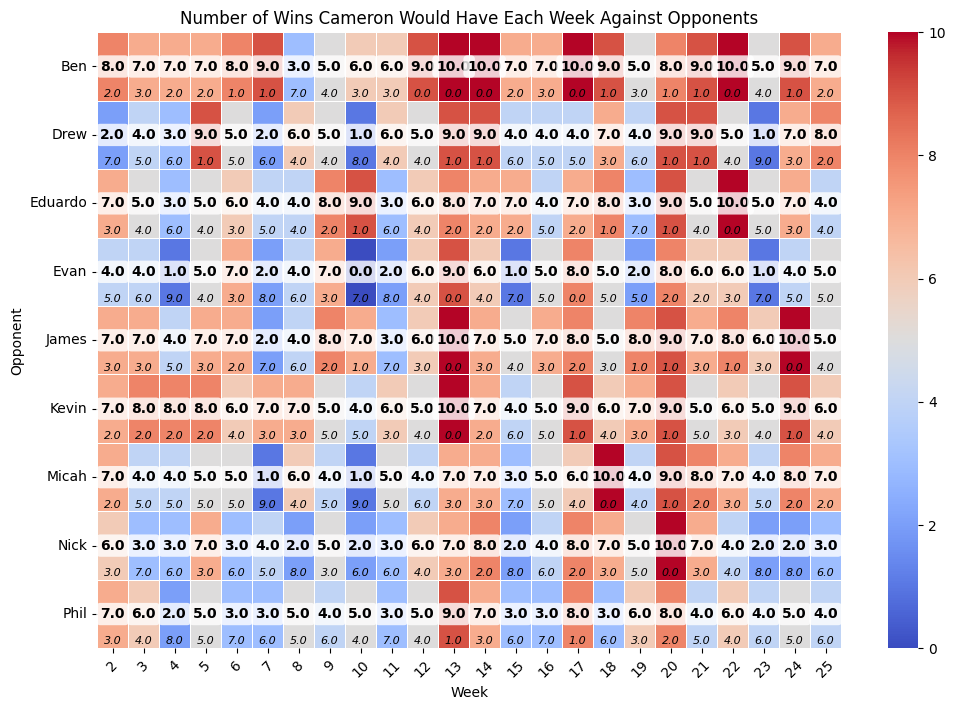

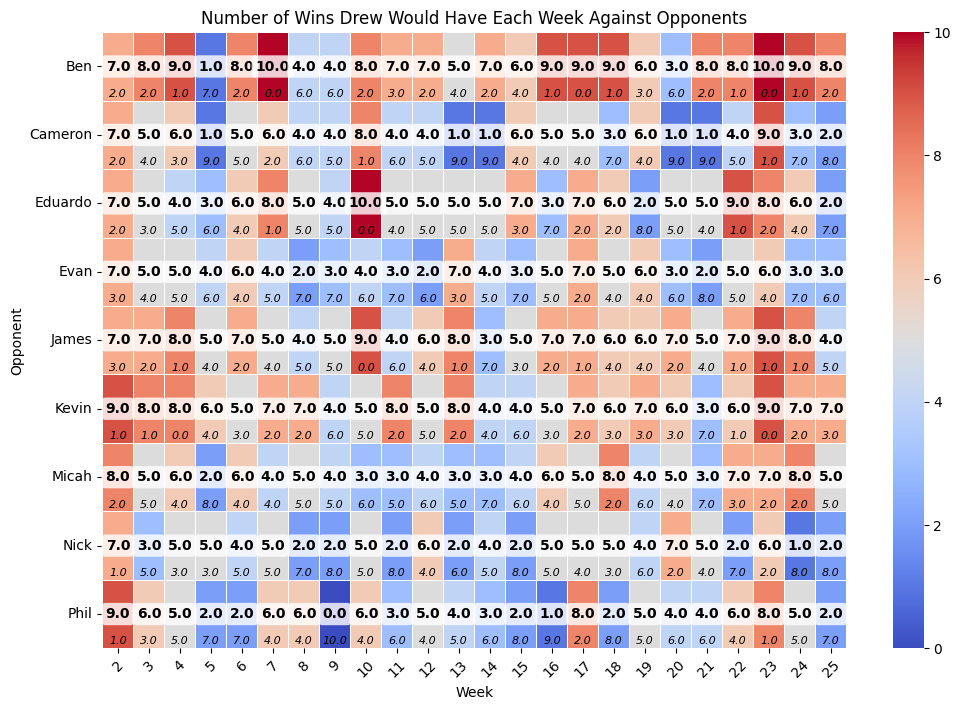

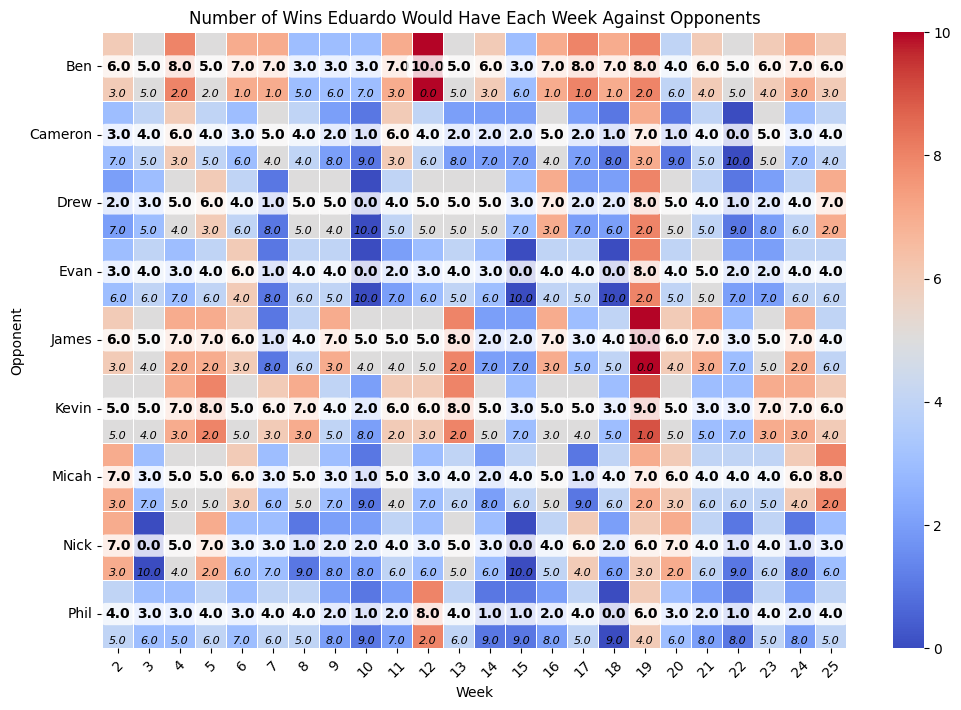

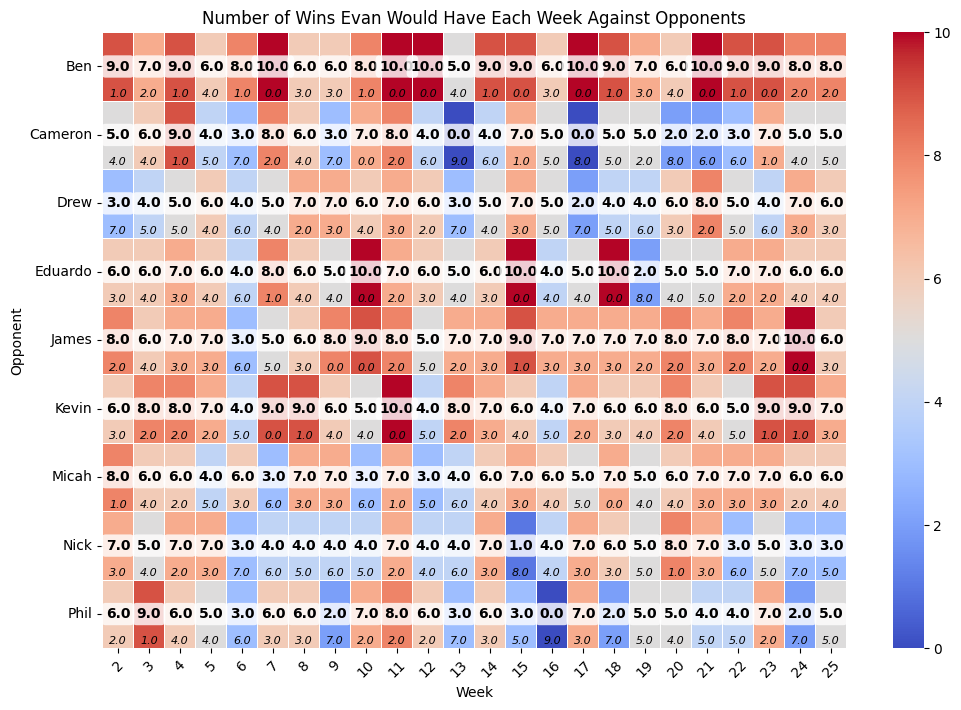

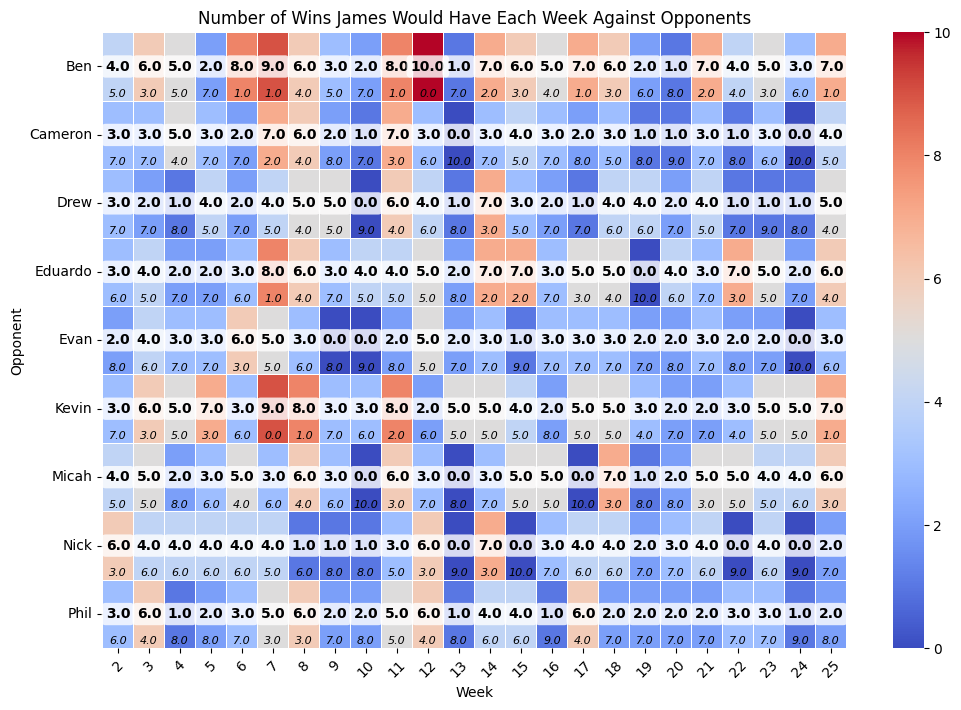

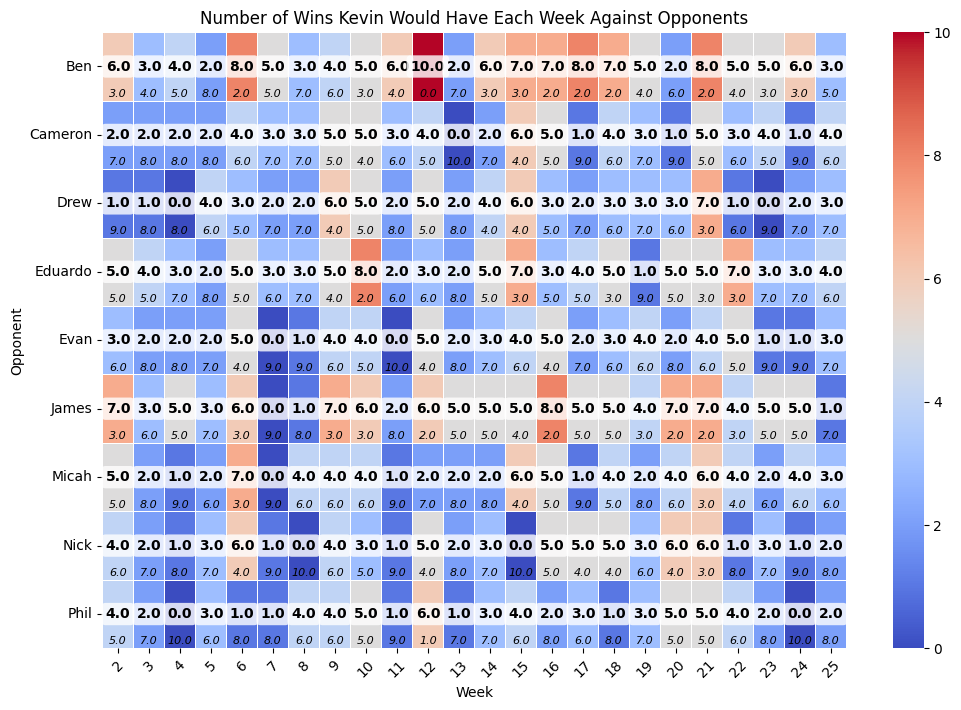

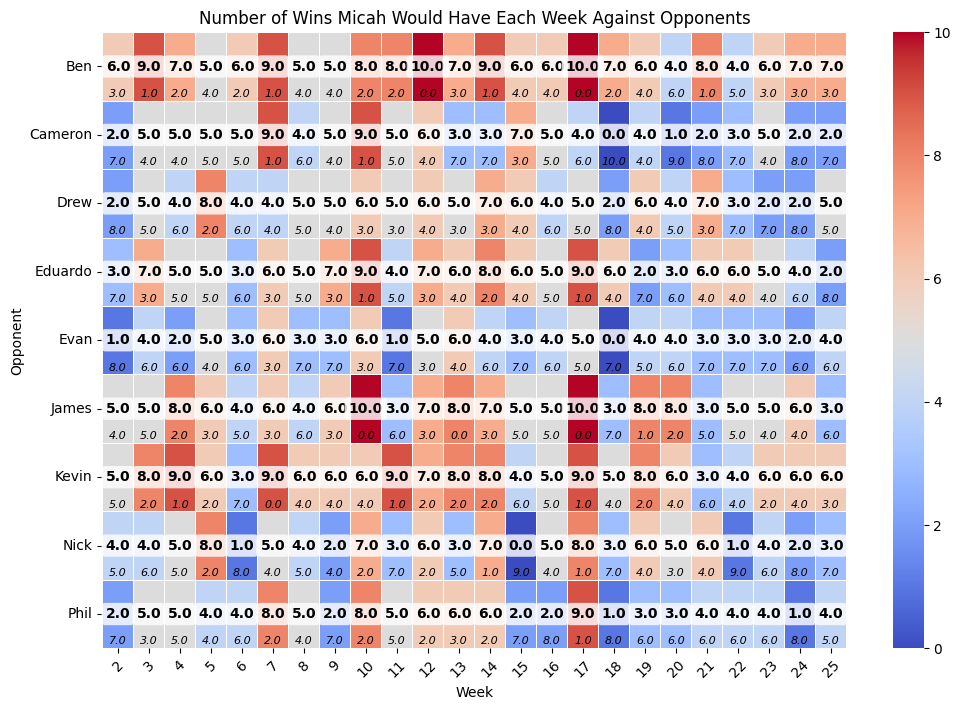

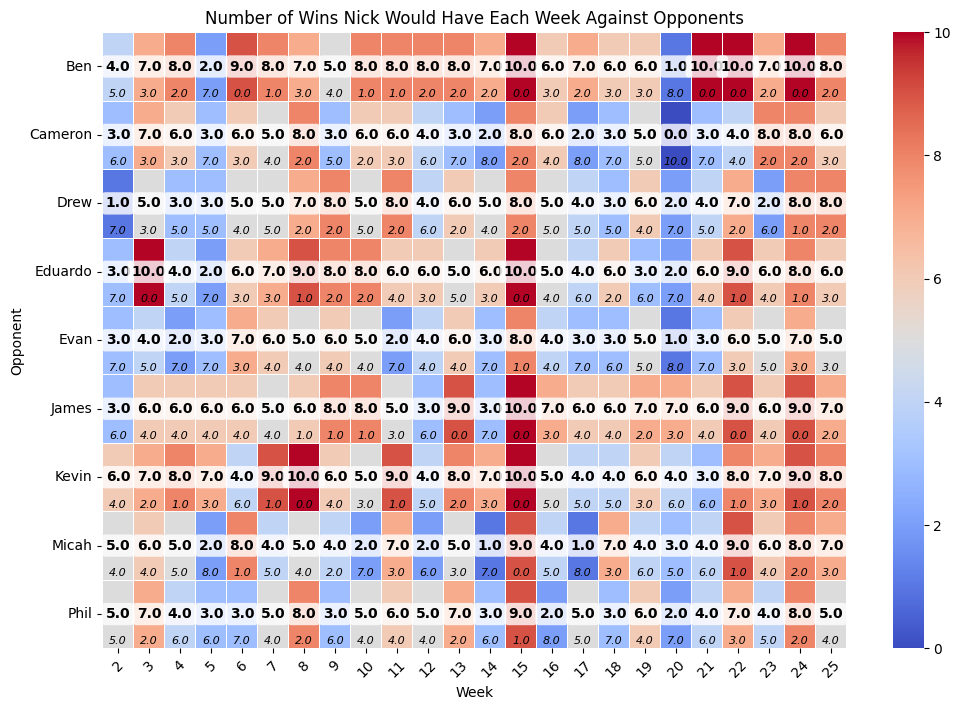

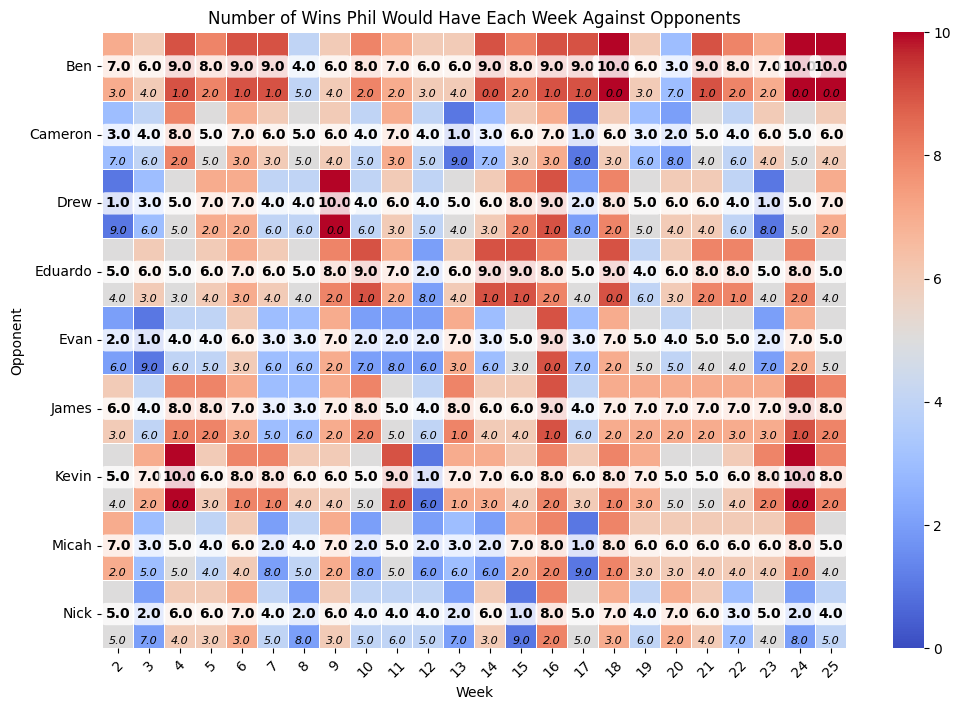

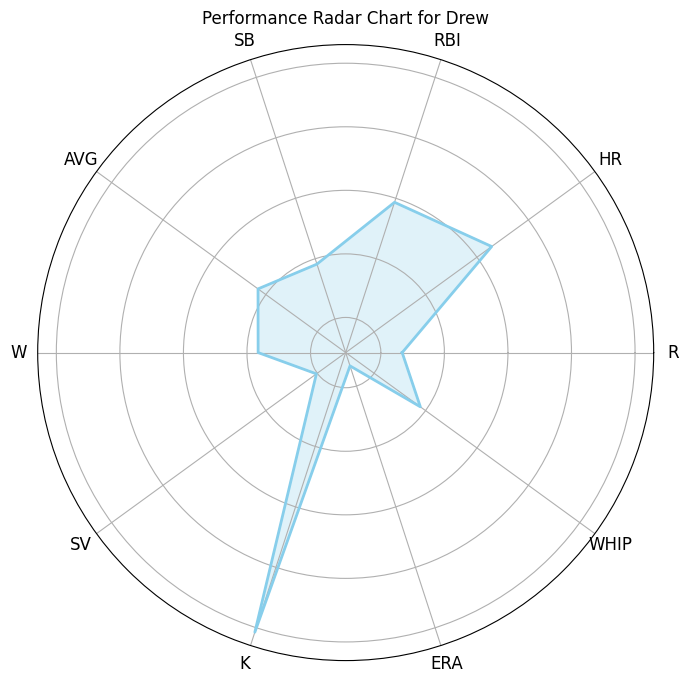

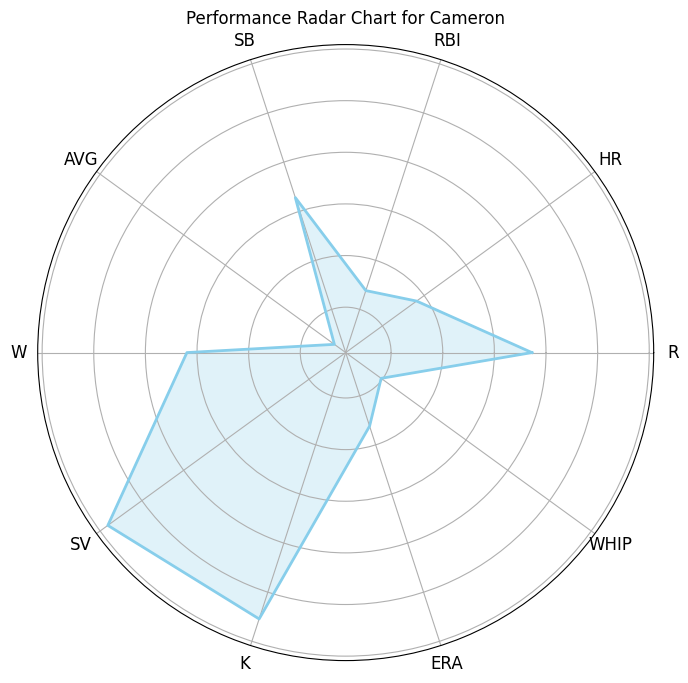

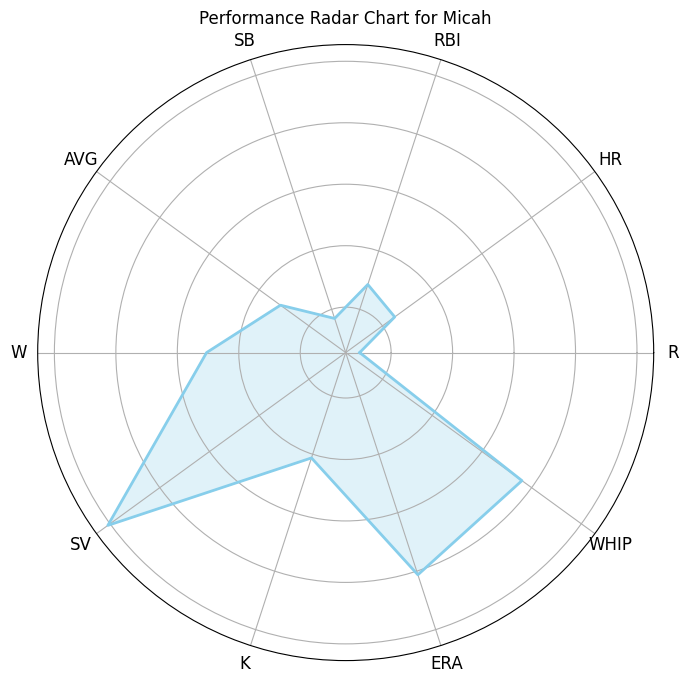

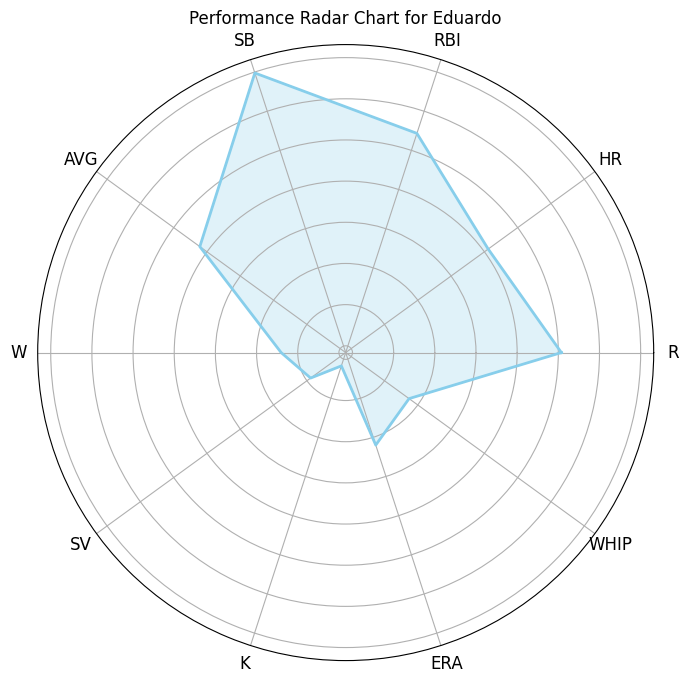

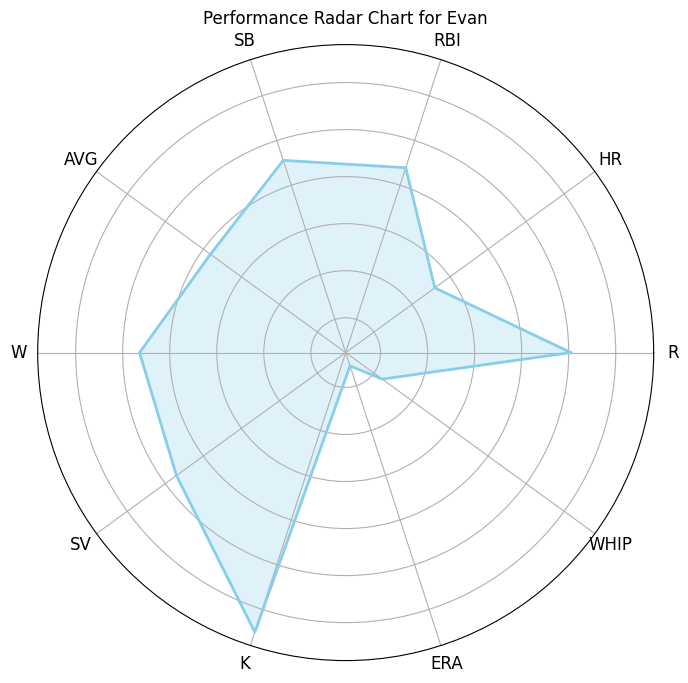

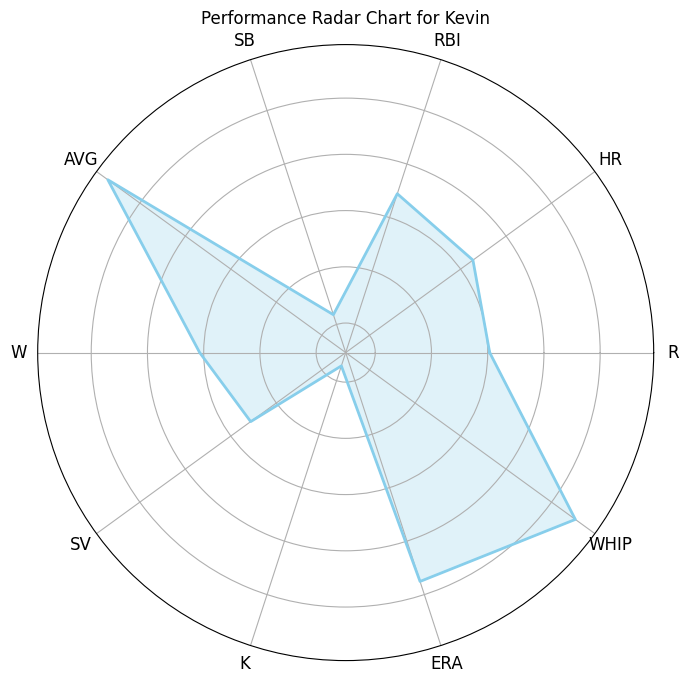

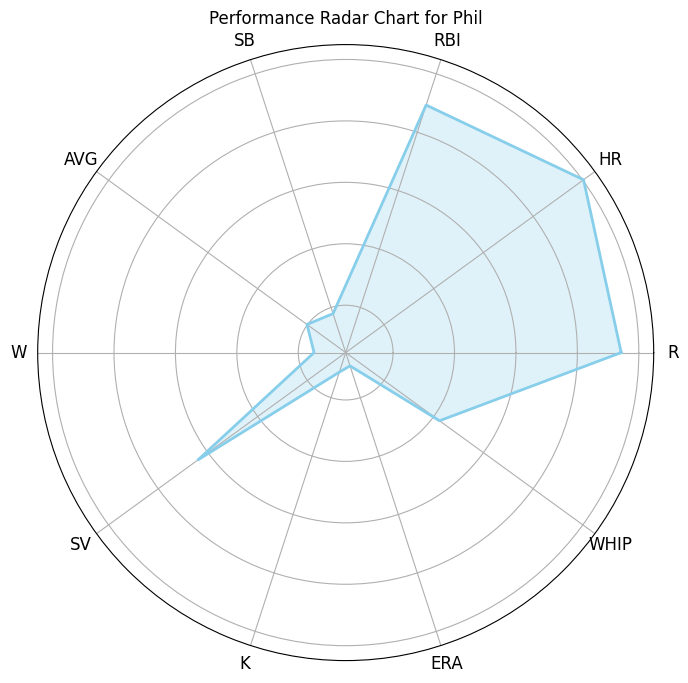

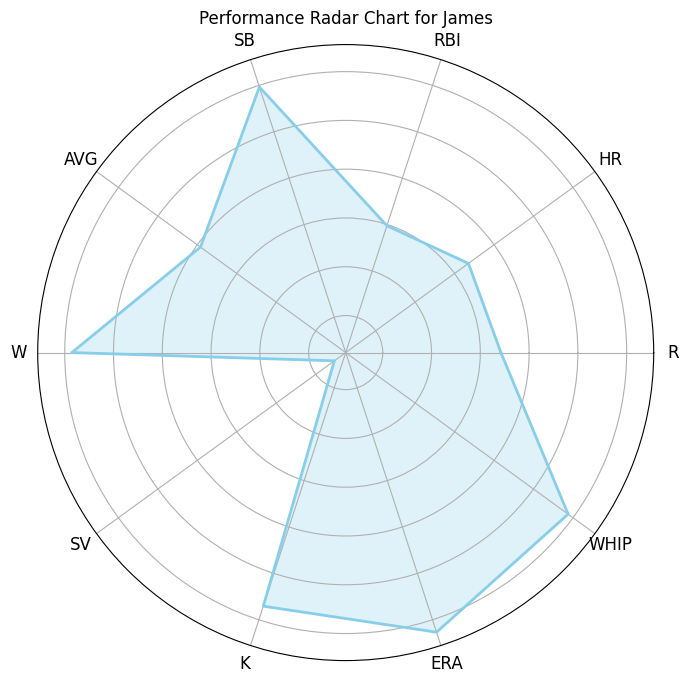

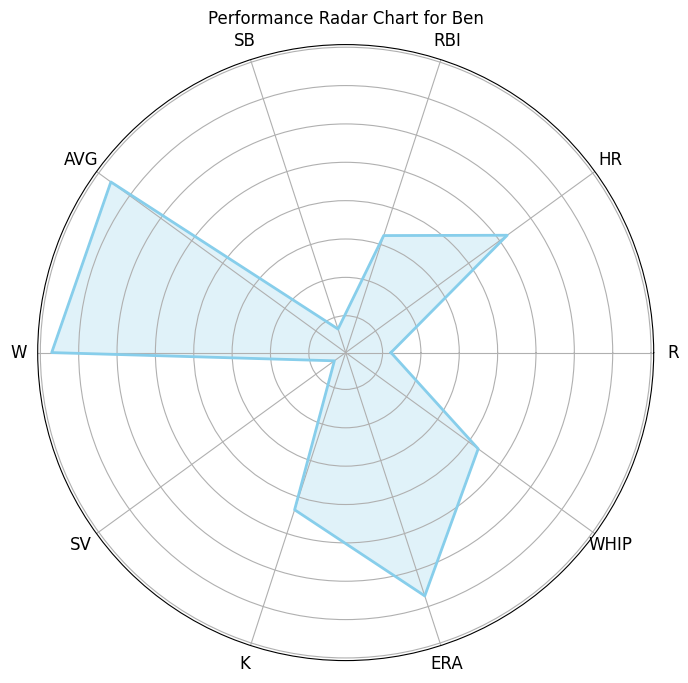

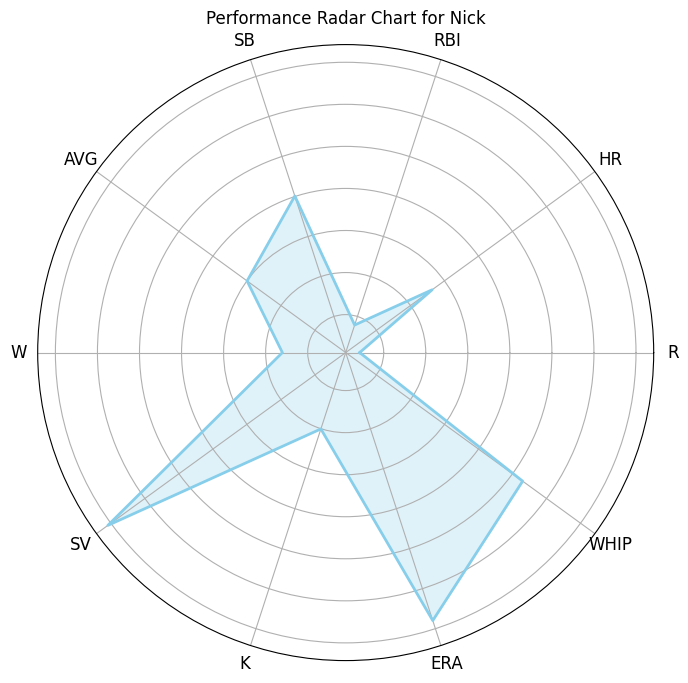

Ben:
  Strengths: 
  Weaknesses: R, HR, RBI, SB, AVG, W, SV, K, ERA, WHIP

Cameron:
  Strengths: R, HR, RBI, SB, W, SV, K, ERA
  Weaknesses: AVG, WHIP

Drew:
  Strengths: R, HR, RBI, SB, AVG, W, SV, K, WHIP
  Weaknesses: ERA

Eduardo:
  Strengths: R, HR, RBI, SB, AVG
  Weaknesses: W, SV, K, ERA, WHIP

Evan:
  Strengths: R, HR, RBI, SB, AVG, W, SV, K
  Weaknesses: ERA, WHIP

James:
  Strengths: ERA
  Weaknesses: R, HR, RBI, SB, AVG, W, SV, K, WHIP

Kevin:
  Strengths: AVG, WHIP
  Weaknesses: R, HR, RBI, SB, W, SV, K, ERA

Micah:
  Strengths: W, SV, K, ERA, WHIP
  Weaknesses: R, HR, RBI, SB, AVG

Nick:
  Strengths: HR, SB, AVG, W, SV, K, ERA, WHIP
  Weaknesses: R, RBI

Phil:
  Strengths: R, HR, RBI, AVG, SV, WHIP
  Weaknesses: SB, W, K, ERA



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Ensure inline plotting in Jupyter
%matplotlib inline

# Ensure the ../Results/ directory exists
def ensure_results_dir():
    results_dir = '../Results/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    return results_dir

# Load and prepare data functions
def load_data(filepath):
    xls = pd.ExcelFile(filepath)
    df_list = []
    for sheet_name in xls.sheet_names:
        sheet_data = pd.read_excel(xls, sheet_name)
        sheet_data['Player'] = sheet_name
        sheet_data['Week'] = pd.to_numeric(sheet_data['Week'], errors='coerce')
        df_list.append(sheet_data)
    data = pd.concat(df_list, ignore_index=True)
    return data

# Function to calculate head-to-head points
def calculate_head_to_head_points(data):
    stats_columns = ['R', 'HR', 'RBI', 'SB', 'AVG', 'W', 'SV', 'K', 'ERA', 'WHIP']
    weekly_points = []

    for week in data['Week'].unique():
        weekly_data = data[data['Week'] == week]
        players = weekly_data['Player'].unique()
        week_points = {player: 0 for player in players}

        for stat in stats_columns:
            for i, player1 in enumerate(players):
                for j, player2 in enumerate(players):
                    if i >= j:  # Avoid duplicate comparisons and self-comparisons
                        continue
                    player1_stat = weekly_data[weekly_data['Player'] == player1][stat].values[0]
                    player2_stat = weekly_data[weekly_data['Player'] == player2][stat].values[0]

                    if stat in ['ERA', 'WHIP']:  # For these stats, lower is better
                        if player1_stat < player2_stat:
                            week_points[player1] += 1
                        elif player1_stat > player2_stat:
                            week_points[player2] += 1
                        else:
                            week_points[player1] += 0.5
                            week_points[player2] += 0.5
                    else:
                        if player1_stat > player2_stat:
                            week_points[player1] += 1
                        elif player1_stat < player2_stat:
                            week_points[player2] += 1
                        else:
                            week_points[player1] += 0.5
                            week_points[player2] += 0.5
        
        for player, points in week_points.items():
            weekly_points.append({'Player': player, 'Week': week, 'Points': points})

    return pd.DataFrame(weekly_points)

# Prepare clustering data
def prepare_clustering_data(data):
    metrics_to_show = ['R', 'HR', 'ERA', 'WHIP', 'RBI', 'SB', 'K', 'SV', 'W', 'AVG']
    numeric_data = data[['Player'] + metrics_to_show]
    aggregated_data = numeric_data.groupby('Player').mean()
    return aggregated_data

# Filter most recent week
def filter_most_recent_week(data):
    most_recent_week = data['Week'].max()
    return data[data['Week'] == most_recent_week]

# PCA function
def run_pca(data, title_suffix=''):
    batting_stats = ['R', 'HR', 'RBI', 'SB', 'AVG']
    pitching_stats = ['W', 'SV', 'K', 'ERA', 'WHIP']
    player_stats = data.groupby('Player').mean(numeric_only=True).reset_index()
    batting_data = player_stats[batting_stats]
    pitching_data = player_stats[pitching_stats]
    imputer = SimpleImputer(strategy='mean')
    batting_data_imputed = imputer.fit_transform(batting_data)
    pitching_data_imputed = imputer.fit_transform(pitching_data)
    scaler = StandardScaler()
    batting_data_scaled = scaler.fit_transform(batting_data_imputed)
    pitching_data_scaled = scaler.fit_transform(pitching_data_imputed)
    pca_batting = PCA(n_components=1)
    pca_pitching = PCA(n_components=1)
    pc1_batting = pca_batting.fit_transform(batting_data_scaled)
    pc2_pitching = pca_pitching.fit_transform(pitching_data_scaled)
    pca_results = pd.DataFrame({
        'Player': player_stats['Player'], 
        'PC1_Batting': pc1_batting.flatten(), 
        'PC2_Pitching': pc2_pitching.flatten()
    })
    pca_results['PCA_Type'] = title_suffix
    return pca_results

# Plot PCA results
def plot_pca(pca_results, results_dir):
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_results['PC1_Batting'], pca_results['PC2_Pitching'])
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')
    for _, row in pca_results.iterrows():
        plt.text(row['PC1_Batting'], row['PC2_Pitching'], row['Player'], fontsize=9)
    plt.xlabel('Principal Component 1 (Batting)')
    plt.ylabel('Principal Component 2 (Pitching)')
    plt.title(f'PCA: Batting vs Pitching ({pca_results["PCA_Type"].iloc[0]})')
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f'PCA_Batting_vs_Pitching_{pca_results["PCA_Type"].iloc[0]}.png'))
    plt.show()

# Plot average stats with unified dot colors and shapes
def plot_average_stat(data, stat, results_dir):
    data = data.dropna(subset=['Week', stat])
    weekly_data = data.groupby(['Player', 'Week'])[stat].mean().reset_index()
    weekly_avg_std = weekly_data.groupby('Player')[stat].agg(['mean', 'std'])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Sort players by their average stat for consistent bar order
    weekly_avg_std = weekly_avg_std.sort_values(by='mean', ascending=False)
    
    # Plot bars with error bars
    bars = ax.bar(weekly_avg_std.index, weekly_avg_std['mean'], yerr=weekly_avg_std['std'], 
                  color='lightgreen', capsize=5, error_kw={'ecolor': 'black', 'capthick': 2})
    
    # Plot individual points for each week
    for i, player in enumerate(weekly_avg_std.index):
        player_data = weekly_data[weekly_data['Player'] == player]
        
        # Scatter the points for each week (all dots have the same color and shape now)
        ax.scatter([i] * len(player_data), player_data[stat], color='black', s=50, marker='o')
    
    # Customize the plot
    ax.set_title(f'Average {stat} per Week by Player')
    ax.set_xlabel('Player')
    ax.set_ylabel(f'Average {stat} per Week')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save the plot
    plt.savefig(os.path.join(results_dir, f'{stat}_average_per_week.png'))
    plt.show()
    plt.close()

# Plot total stats per player
def plot_stat(data, stat, results_dir):
    data = data.dropna(subset=[stat])
    
    # For batting average (AVG), calculate the mean instead of sum
    if stat == 'AVG':
        season_totals = data.groupby('Player')[stat].mean().reset_index().sort_values(by=stat, ascending=False)
    else:
        season_totals = data.groupby('Player')[stat].sum().reset_index().sort_values(by=stat, ascending=False)
    
    max_value = season_totals[stat].max()
    
    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    norm = Normalize(0, max_value)
    cmap = ScalarMappable(norm=norm, cmap='viridis')
    
    bars = ax.bar(season_totals['Player'], season_totals[stat], color=[cmap.to_rgba(x) for x in season_totals[stat]])
    
    # Annotate the bars with the total values
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 3 if stat == 'AVG' else 2), ha='center', va='bottom')
    
    # Customize the plot
    ax.set_title(f'Season Total {stat} by Player')
    ax.set_xlabel('Player')
    ax.set_ylabel(f'Total {stat}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save the plot
    plt.savefig(os.path.join(results_dir, f'{stat}_season_total.png'))
    plt.show()
    plt.close()

# Head-to-head comparison
def head_to_head_comparison(data, stats, results_dir):
    weekly_data = data.groupby(['Player', 'Week'])[stats].mean().reset_index()
    players = weekly_data['Player'].unique()
    weeks = weekly_data['Week'].unique()
    results = []
    for week in weeks:
        week_data = weekly_data[weekly_data['Week'] == week]
        for player1 in players:
            for player2 in players:
                if player1 != player2:
                    player1_data = week_data[week_data['Player'] == player1][stats].values.flatten()
                    player2_data = week_data[week_data['Player'] == player2][stats].values.flatten()
                    comparison = []
                    for stat, p1_val, p2_val in zip(stats, player1_data, player2_data):
                        if stat in ['WHIP', 'ERA']:
                            if p1_val < p2_val:
                                comparison.append(1)
                            elif p1_val > p2_val:
                                comparison.append(-1)
                            else:
                                comparison.append(0)
                        else:
                            if p1_val > p2_val:
                                comparison.append(1)
                            elif p1_val < p2_val:
                                comparison.append(-1)
                            else:
                                comparison.append(0)
                    win = comparison.count(1)
                    results.append({
                        'Week': week,
                        'Player1': player1,
                        'Player2': player2,
                        'Wins': win
                    })
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(results_dir, 'head_to_head_comparisons.csv'), index=False)
    print('Head-to-head comparisons saved to ../Results/head_to_head_comparisons.csv')
    return results_df

# Visualize head-to-head heatmap
def visualize_head_to_head(results_df, results_dir):
    players = results_df['Player1'].unique()
    for player in players:
        player_df = results_df[results_df['Player1'] == player].pivot_table(index='Player2', columns='Week', values='Wins')
        
        # Prepare a DataFrame to include opponent's scores
        opponent_scores_df = results_df[results_df['Player2'] == player].pivot_table(index='Player1', columns='Week', values='Wins')
        opponent_scores_df = opponent_scores_df.reindex(index=player_df.index, columns=player_df.columns)
        
        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(player_df, annot=False, fmt=".1f", cmap='coolwarm', linewidths=.5, cbar=True, vmin=0, vmax=10)

        for (i, j), val in np.ndenumerate(player_df):
            opponent_val = opponent_scores_df.iat[i, j]
            # Main text
            plt.text(j + 0.5, i + 0.5, f'{val:.1f}', ha='center', va='center',
                     fontsize=10, weight='bold', color='black',
                     bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='white', alpha=0.8))
            # Opponent's score
            plt.text(j + 0.5, i + 0.9, f'{opponent_val:.1f}', ha='center', va='center',
                     fontsize=8, weight='light', color='black', style='italic')
        
        plt.title(f'Number of Wins {player} Would Have Each Week Against Opponents')
        plt.xlabel('Week')
        plt.ylabel('Opponent')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        
        # Save the heatmap to ../Results
        plt.savefig(os.path.join(results_dir, f'weekly_head_to_head_heatmap_{player}.png'))
        plt.show()
        plt.close()

# Plot radar chart
def plot_radar_chart(data, stats, results_dir):
    players = data['Player'].unique()
    
    # Identify the stats where lower values are better
    inverse_stats = ['ERA', 'WHIP']
    
    # Invert the values for these stats
    for stat in inverse_stats:
        data[stat] = -data[stat]
    
    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[stats])
    data[stats] = scaled_data
    
    for player in players:
        player_data = data[data['Player'] == player][stats].mean().values
        num_vars = len(stats)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        values = player_data.tolist()
        values += values[:1]
        angles += angles[:1]
        
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
        ax.fill(angles, values, color='skyblue', alpha=0.25)
        ax.plot(angles, values, color='skyblue', linewidth=2)
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(stats, size=12)
        plt.title(f'Performance Radar Chart for {player}')
        
        # Save radar chart to ../Results
        plt.savefig(os.path.join(results_dir, f'radar_chart_{player}.png'))
        plt.show()
        plt.close()

# Analyze team strengths and weaknesses
def analyze_team_strengths_weaknesses(data, stats):
    average_stats = data.groupby('Player')[stats].mean().reset_index()
    league_averages = data[stats].mean()
    
    strengths_weaknesses = {}
    
    for player in average_stats['Player'].unique():
        player_stats = average_stats[average_stats['Player'] == player][stats].iloc[0]
        strengths = player_stats[player_stats > league_averages].index.tolist()
        weaknesses = player_stats[player_stats <= league_averages].index.tolist()
        strengths_weaknesses[player] = {
            'Strengths': strengths,
            'Weaknesses': weaknesses
        }
    
    for player, analysis in strengths_weaknesses.items():
        print(f'{player}:')
        print(f"  Strengths: {', '.join(analysis['Strengths'])}")
        print(f"  Weaknesses: {', '.join(analysis['Weaknesses'])}")
        print('')

    return strengths_weaknesses

# Main function
def main():
    filepath = '../Data/Yahoo-431.l.148152-Matchups-Manual.xlsx'
    results_dir = ensure_results_dir()  # Ensure results folder
    data = load_data(filepath)  # Load data here
    stats_to_plot = ['R', 'HR', 'RBI', 'SB', 'AVG', 'W', 'SV', 'K', 'ERA', 'WHIP']
    
    # Plot statistics and display/save them in ../Results/
    for stat in stats_to_plot:
        plot_stat(data, stat, results_dir)
        plot_average_stat(data, stat, results_dir)
        
    # Run PCA for the season and save plot in ../Results/
    pca_results_season = run_pca(data, title_suffix='Season')
    plot_pca(pca_results_season, results_dir)
    
    # Run PCA for the most recent week and save plot
    most_recent_week_data = filter_most_recent_week(data)
    pca_results_weekly = run_pca(most_recent_week_data, title_suffix='Most Recent Week')
    plot_pca(pca_results_weekly, results_dir)
    
    # Calculate head-to-head comparison, save, and visualize
    results_df = head_to_head_comparison(data, stats_to_plot, results_dir)
    visualize_head_to_head(results_df, results_dir)  # Add results_dir to visualize heatmaps
    
    # Save radar charts to ../Results
    plot_radar_chart(data, stats_to_plot, results_dir)
    
    # Analyze team strengths and weaknesses
    analyze_team_strengths_weaknesses(data, stats_to_plot)

# Call the main function
if __name__ == "__main__":
    main()